In [ ]:
!unzip '/content/drive/MyDrive/image segmentation/1.3 Healthcare AI Datasets.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_12_mask.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_13_mask.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_14_mask.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_15.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_15_mask.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_16.tif  
  inflating: Healthcare AI Datasets/Brain_MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_16_mask.tif  
  inflating: Healthcare AI Datase

In [ ]:
#importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,Xception
from keras.metrics import Accuracy,BinaryAccuracy,Precision,Recall
from tensorflow.keras import layers
from keras.layers import *
from tensorflow.keras import Model
from  keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras import applications
from keras.models import Sequential
from tensorflow import keras
import tensorflow as tf
from keras.initializers import HeNormal
from sklearn.metrics import classification_report
from keras.models import load_model
from skimage import io
from keras import backend as K
import cv2
import tensorflow as tf
import os 
from skimage import io

In [ ]:
# reading the mask file
train=pd.read_csv("/content/Healthcare AI Datasets/Brain_MRI/data_mask.csv")
print("total number of rows",train.shape[0])
train.head(10) 


total number of rows 3929


,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
5,TCGA_CS_5395_19981004,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0
6,TCGA_CS_5395_19981004,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
7,TCGA_CS_5395_19981004,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_...,0
8,TCGA_CS_5395_19981004,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_...,0
9,TCGA_CS_5395_19981004,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_...,0


In [ ]:
train.shape

(3929, 4)

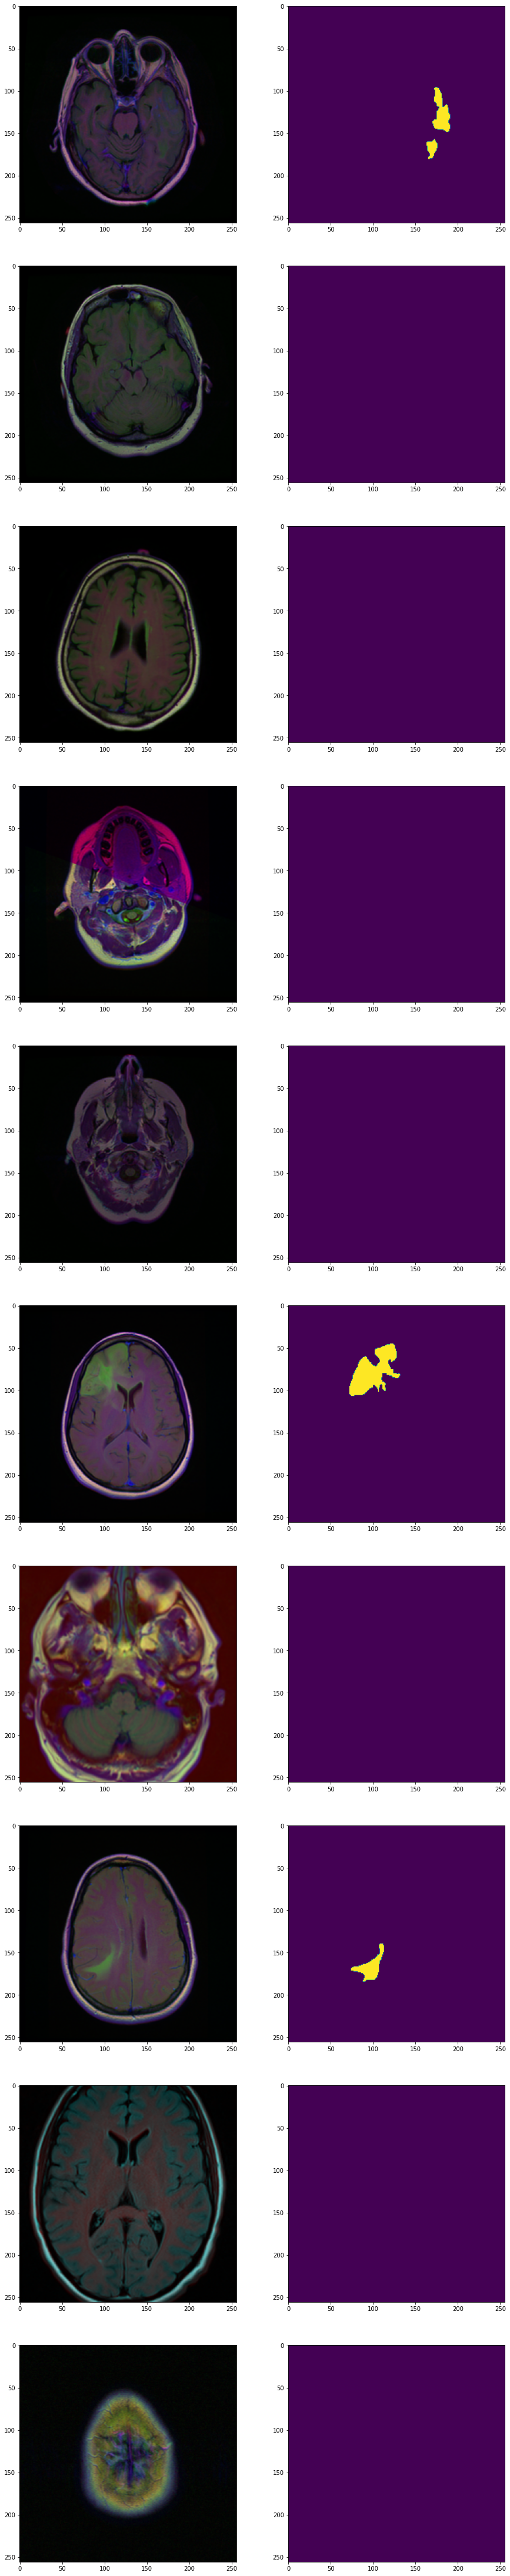

In [ ]:
fig,ax=plt.subplots(10,2,figsize=(15,80))
for i in range(10):
  no=random.randint(0,train.shape[0])
  ax[i][0].imshow(imread('/content/Healthcare AI Datasets/Brain_MRI/'+train['image_path'].iloc[no]))
  ax[i][1].imshow(imread('/content/Healthcare AI Datasets/Brain_MRI/'+train['mask_path'].iloc[no]))

In [ ]:
#Converting the mask column values to string
train["mask"]=train['mask'].apply(lambda x: str(x))


In [ ]:
train,test=train_test_split(train,test_size=0.15,random_state=2)
#dividing into train test validation 

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.15,rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                    zoom_range=0.2, fill_mode='nearest', horizontal_flip=True)
#validation split is of 0.15% of train split

traingen=datagen.flow_from_dataframe(dataframe=train,
              directory='/content/Healthcare AI Datasets/Brain_MRI/',
              batch_size=32,class_mode='binary',subset="training",
              shuffle=True,x_col='image_path',y_col='mask',seed=2)

#validation ->0.15 of train
validation=datagen.flow_from_dataframe(dataframe=train,
    batch_size=32,x_col='image_path',
    y_col='mask',
    subset="validation",class_mode='binary',shuffle=True,
    directory='/content/Healthcare AI Datasets/Brain_MRI',seed=2

)

#test 0.15 of total
testg=ImageDataGenerator(rescale=1./255.)
testgen=testg.flow_from_dataframe(dataframe=test,class_mode='binary',
                x_col='image_path',y_col='mask',shuffle=False,batch_size=32,
                directory='/content/Healthcare AI Datasets/Brain_MRI',seed=2)

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
traingen.target_size,traingen.n,validation.target_size,validation.n,testgen.target_size,testgen.n

((256, 256), 2839, (256, 256), 500, (256, 256), 590)

**Modelling**


In [ ]:
#USing the transfer learning 
rs=Xception(weights='imagenet',include_top=False,input_shape=[256,256,3])

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
#Adding the last layers to the Xception model
model=rs.output
model=AveragePooling2D()(model)
model=Flatten()(model)
model=Dense(128,activation='relu',kernel_initializer=HeNormal(seed=2))(model)
model=Dense(1,activation='sigmoid')(model)
final=Model(inputs=rs.input,outputs=model)

In [ ]:
#compiling the model
final.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=Adam())

In [ ]:

early=EarlyStopping(monitor='val_accuracy',patience=4,verbose=1,mode='max',restore_best_weights=True)
reduce_learning_rate_cb = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.00001, verbose=1)

In [ ]:
final.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
#fitting the model 
history1=final.fit(traingen,validation_data=validation,epochs=30,callbacks=[early,reduce_learning_rate_cb])

Epoch 1/30
47/47 [==============================] - 39s 711ms/step - loss: 0.9289 - accuracy: 0.6197 - val_loss: 0.5767 - val_accuracy: 0.6398
Epoch 2/30
47/47 [==============================] - 32s 687ms/step - loss: 0.4739 - accuracy: 0.7505 - val_loss: 0.5175 - val_accuracy: 0.7395
Epoch 3/30
47/47 [==============================] - 33s 688ms/step - loss: 0.3818 - accuracy: 0.8334 - val_loss: 2.3495 - val_accuracy: 0.8736
Epoch 4/30
47/47 [==============================] - 32s 684ms/step - loss: 0.3082 - accuracy: 0.8717 - val_loss: 0.5010 - val_accuracy: 0.9272
Epoch 5/30
47/47 [==============================] - 33s 689ms/step - loss: 0.1945 - accuracy: 0.9301 - val_loss: 1.2787 - val_accuracy: 0.8812
Epoch 6/30
47/47 [==============================] - 32s 686ms/step - loss: 0.2053 - accuracy: 0.9256 - val_loss: 1.2127 - val_accuracy: 0.7548
Epoch 7/30
47/47 [==============================] - 33s 688ms/step - loss: 0.1608 - accuracy: 0.9335 - val_loss: 0.8049 - val_accuracy: 0.8582

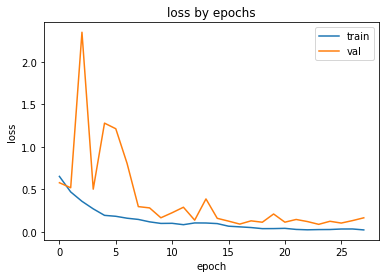

In [ ]:
#plotting the loss vs epochs
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('loss by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

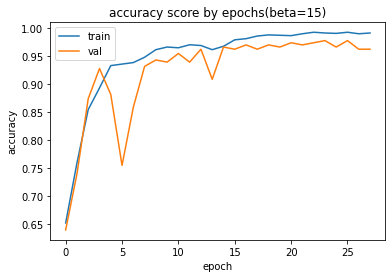

In [ ]:
#plotting the accuracy vs epoch
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('accuracy score by epochs(beta=15)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
#Saving the final model
final.save("/content/drive/MyDrive/model.h5")

In [ ]:
#predicting the test data
pred=final.predict(testgen)

In [ ]:
#converting the probabilities to the actual classes
predictions2=[1  if i > 0.5 else 0 for i in pred]
predictions2=np.array(predictions2)
real=np.array(testgen.classes)
predictions2

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [ ]:

print(classification_report(testgen.classes,predictions2))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       212
           1       0.95      0.97      0.96        96

    accuracy                           0.97       308
   macro avg       0.97      0.97      0.97       308
weighted avg       0.97      0.97      0.97       308



1


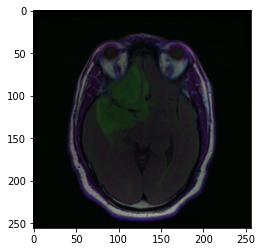

In [ ]:
#Predicting a single image

img=imread('/content/Healthcare AI Datasets/Brain_MRI/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_14.tif')
imgplot = plt.imshow(img)
img = tf.expand_dims(img,0) # need this to make batch_shape = 1
img=img/255  # normalizing the image
img=tf.image.resize(img,size=(256, 256)) # resizing image
Prob=final.predict(img) # prediction
if Prob<0.5:
  print(0)
else:
  print(1)

